# CNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
plt.rcParams['font.size'] = 14

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

2022-04-01 18:21:03.529851: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-01 18:21:03.529883: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Load data

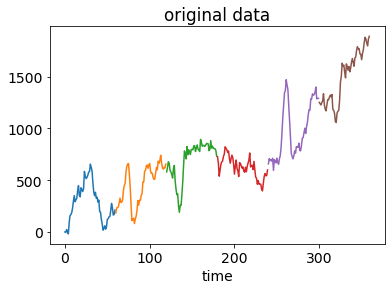

data:  20000
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [2]:
str0 = f'ts_L60_Z12_A500_DX50_bias5_N20000.dat'
fnamex = 'DATA/x_' + str0
fnamey = 'DATA/y_' + str0

x = np.loadtxt(fnamex, delimiter=' ', dtype=float)
N, L = len(x), len(x[0])

# function to plot samples
def Show_data(x, N, s='data'):
    # size of each sample of the timeseries
    L = 60
    # plot the first N samples
    for i in range(N):
        plt.plot(np.arange(i*L,(i+1)*L),x[i])   
    plt.xlabel('time')
    plt.title(s)
    plt.show()

Show_data(x, 6, 'original data')
print('data: ', N)

# build multi-class vector labels
categ = np.loadtxt(fnamey, dtype=int)
n_class = 3
y = np.zeros((N,n_class))
for i in range(N):
    y[i,categ[i]] = 1
print(y[:6])

### Define datasets

In [3]:
# list of the sizes (number of samples) of the datasets
N_samples = np.array([20, 50, 100, 150, 200, 250, 300, 400, 500])

# for each size, select "N_datasets" indipendent datasets
# in order to calculate the standard deviation of the accuracy of the model for each size
N_datasets = 10

# each dataset for each size is divided into training and test set
perc_train = 0.8

# total number of samples needed
print('total number of samples:', np.sum(N_samples*N_datasets))

total number of samples: 19700


### Define the model with Keras

In [4]:
def create_model():

    # initializer
    ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)

    # regularizer
    reg = tf.keras.regularizers.l2(0.1)

    model = Sequential()
    # convolutional layer
    model.add(Conv1D(filters=5, kernel_size=11,
                    kernel_initializer=ini, kernel_regularizer=reg,
                    activation='relu', input_shape=(L,1)))
    # pooling layer                     
    model.add(AveragePooling1D(5))
    # convolutional layer
    model.add(Conv1D(filters=5, kernel_size=7,
                    activation='relu'))
    # fully connected neural network
    model.add(Flatten())
    model.add(Dense(12, activation='relu'))
    model.add(Dropout(0.2))        
    model.add(Dense(n_class, activation='softmax'))

    # compile the model: categorical_crossentropy, 3 output nodes
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='Adam', metrics=['accuracy'])
    
    return model

### Training, test and accuracy

In [5]:
# reproducibility
np.random.seed(12345)
tf.random.set_seed(12345)

acc_cnn = np.zeros((len(N_samples),N_datasets))

for i in range(0, len(N_samples)):

    for j in range(0, N_datasets):

        start = np.sum(N_samples[:i]*N_datasets) + N_samples[i]*j
        end = start + N_samples[i]

        N_train = int(perc_train*N_samples[i])

        # training set
        x_train = x[start:start+N_train]
        y_train = y[start:start+N_train]

        # test set
        x_test = x[start+N_train:end]
        y_test = y[start+N_train:end]

        # rescale

        # remove average value of each sample from its values
        xm_train = x_train.mean(axis=1)
        for k in range(len(x_train)):
            x_train[k] = x_train[k] - xm_train[k]
        xm_test = x_test.mean(axis=1)
        for k in range(len(x_test)):
            x_test[k] = x_test[k] - xm_test[k]

        # rescale all the samples with the train set variance 
        xv = x_train.var()
        x_train = x_train/np.sqrt(xv)
        x_test = x_test/np.sqrt(xv)

        # create the model
        model = create_model()

        # fit the model
        fit = model.fit(x_train, y_train,
                    batch_size=int(N_train/8), epochs=32,
                    verbose=0, shuffle=True)
        print(i,j)
        
        # true labels
        max_y_test = np.argmax(y_test, axis=1)

        # predict labels on test set: take the class with the highest probability
        y_pred = model.predict(x_test)
        max_y_pred = np.argmax(y_pred, axis=1)

        # compute accuracy
        acc_cnn[i,j] = accuracy_score(max_y_test, max_y_pred)

# compute mean and standard deviation of accuracy for each dataset size       
acc_cnn_mean = acc_cnn.mean(axis=1)
acc_cnn_stddev = np.sqrt(acc_cnn.var(axis=1))

2022-04-01 18:21:06.740017: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-01 18:21:06.740055: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-01 18:21:06.740087: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eugenio-HP-Pavilion-Laptop-15-eg0xxx): /proc/driver/nvidia/version does not exist
2022-04-01 18:21:06.740772: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9


In [6]:
print('accuracy matrix:\n', np.round(acc_cnn,4))
print('means:\n', np.round(acc_cnn_mean,4))
print('standard deviations:\n', np.round(acc_cnn_stddev,4))

accuracy matrix:
 [[0.     0.25   0.25   0.     0.25   0.25   0.5    0.     0.25   0.75  ]
 [0.4    0.1    0.4    0.5    0.2    0.3    0.4    0.4    0.5    0.4   ]
 [0.4    0.35   0.55   0.45   0.6    0.5    0.5    0.65   0.35   0.35  ]
 [0.5667 0.7    0.5333 0.3    0.5667 0.6667 0.4667 0.6333 0.4667 0.5667]
 [0.65   0.575  0.6    0.7    0.625  0.775  0.425  0.6    0.75   0.625 ]
 [0.66   0.66   0.56   0.64   0.66   0.78   0.54   0.56   0.68   0.54  ]
 [0.7    0.6    0.7167 0.55   0.4833 0.4833 0.6167 0.5    0.6667 0.6167]
 [0.675  0.65   0.825  0.6375 0.75   0.625  0.6875 0.5375 0.7    0.6625]
 [0.72   0.68   0.63   0.72   0.74   0.56   0.78   0.73   0.72   0.59  ]]
means:
 [0.25   0.36   0.47   0.5467 0.6325 0.628  0.5933 0.675  0.687 ]
standard deviations:
 [0.2236 0.12   0.103  0.1097 0.0936 0.0733 0.0824 0.0725 0.0674]


### Plot mean and standard deviation of accuracy vs dataset size

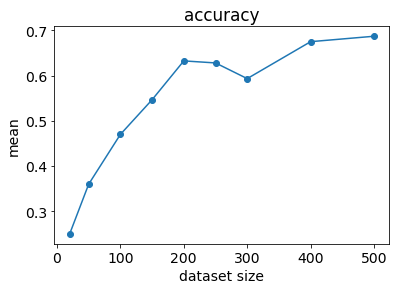

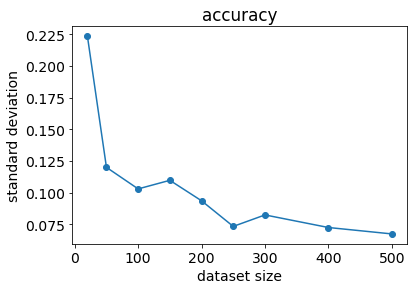

In [7]:
plt.plot(N_samples, acc_cnn_mean, '-o')
plt.xlabel('dataset size')
plt.ylabel('mean')
plt.title('accuracy')
plt.show()

plt.plot(N_samples, acc_cnn_stddev, '-o')
plt.xlabel('dataset size')
plt.ylabel('standard deviation')
plt.title('accuracy')
plt.show()

# XGBoost

https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html

In [8]:
import pandas as pd

from tsfresh import extract_features
from xgboost import XGBClassifier, plot_tree

/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Load data

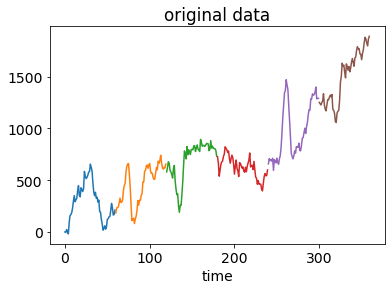

data: 20000
[0 1 2 0 1 2]


In [9]:
str0 = 'ts_L60_Z12_A500_DX50_bias5_N20000.dat'
fnamex = 'DATA/x_' + str0
fnamey = 'DATA/y_' + str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N, L = len(x), len(x[0])

Show_data(x, 6, 'original data')
print('data:', N)

# note: here it does not need to be converted to the 3-bit version, a label remains y[i]=0,1,2
y = np.loadtxt(fnamey, dtype=int)
n_class = 3
print(y[:6])

### tsfresh

Input data format: DATAFRAME

first column $\to$ id of the sample \
second column $\to$  id of the time step \
third column $\to$ value of the feature of _id_-sample at _id_-step

For more: https://tsfresh.readthedocs.io/en/latest/text/data_formats.html

### Build dataframe

In [10]:
def get_df(x):
    '''Build input dataframe for given data series
    Input:
    var = array of time series, (#samples,time,1)
    Return:
    df = dataframe ready for features extraction
    '''
    
    # N=#samples, t=timesteps
    N, t = x.shape[0], x.shape[1]
    # build id columns
    id_col = np.repeat(np.arange(N),t)
    # build time columns
    time_col = np.tile(np.arange(t),N)
    # build var columns
    x_col = x.flatten()
      
    # build dict for df
    x_dict = {'id':id_col,'time':time_col,'value':x_col}
        
    # return dataframe
    return pd.DataFrame(x_dict)

In [11]:
# get df
df = get_df(x) 

# check that last columns, if reshaped is equal to x
#df_to_array = df.values[:,-1].reshape(x.shape[0],x.shape[1])
#sum of different values: should be 0
#print('Differences:',np.sum(df_to_array != x))

df

,id,time,value
0,0,0,0.0
1,0,1,-5.0
2,0,2,23.0
3,0,3,3.0
4,0,4,-19.0
...,...,...,...
1199995,19999,55,5941150.0
1199996,19999,56,5941160.0
1199997,19999,57,5941043.0
1199998,19999,58,5941123.0


### Extract features 

In [12]:
# extract features
x_features = extract_features(
                            df, # our dataframe
                            column_id='id', # sample id, from 0 to N
                            column_sort='time', # timestep, from 0 to t
                            column_kind=None, # we have only one feature
                            column_value='value', # value of input 
                            n_jobs=4) # number of cores

Feature Extraction: 100%|███████████████████████| 20/20 [12:11<00:00, 36.55s/it]


In [13]:
# look at x_features
x_features

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,"value__matrix_profile__feature_""min""__threshold_0.98","value__matrix_profile__feature_""max""__threshold_0.98","value__matrix_profile__feature_""mean""__threshold_0.98","value__matrix_profile__feature_""median""__threshold_0.98","value__matrix_profile__feature_""25""__threshold_0.98","value__matrix_profile__feature_""75""__threshold_0.98",value__mean_n_absolute_max__number_of_maxima_7
0,1.0,0.0,0.0,1.0,16750.0,6.729150e+06,43.101695,3.576271,0.405172,289.5,...,3.608440,3.809279,NaN,0.731923,3.235582,1.491836,1.414559,1.093670,1.850822,5.945714e+02
1,1.0,0.0,0.0,1.0,27302.0,1.455619e+07,44.000000,8.033898,-0.086207,509.5,...,3.462655,3.659720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.811429e+02
2,1.0,0.0,0.0,1.0,41650.0,3.090479e+07,45.491525,2.576271,-0.862069,784.0,...,4.007333,3.988984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.632857e+02
3,1.0,0.0,0.0,1.0,37428.0,2.393510e+07,44.372881,-2.169492,1.008621,631.0,...,3.871793,3.937640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.844286e+02
4,1.0,0.0,0.0,1.0,58260.0,6.072359e+07,54.593220,10.728814,-0.422414,909.0,...,3.575507,3.773917,NaN,0.798380,4.985956,2.381229,1.596584,1.268636,4.166435,1.389857e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1.0,0.0,0.0,1.0,356340007.0,2.116303e+15,36.016949,5.406780,-0.189655,5938968.5,...,3.906512,3.963312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.939236e+06
19996,1.0,0.0,0.0,1.0,356379434.0,2.116772e+15,53.627119,22.779661,-1.448276,5939727.5,...,3.376707,3.635867,NaN,0.823222,4.662838,2.247026,1.885375,1.300430,2.898579,5.940137e+06
19997,1.0,0.0,0.0,1.0,356421302.0,2.117269e+15,49.423729,2.474576,-0.491379,5940410.5,...,3.846587,3.988984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.940534e+06
19998,1.0,0.0,0.0,1.0,356455577.0,2.117676e+15,41.593220,13.186441,-0.327586,5941009.0,...,3.734994,3.886296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.941160e+06


In [14]:
# remove columns with NaN or inf
x_features.replace([np.inf, -np.inf], np.nan, inplace=True)
x_features = x_features.dropna(axis='columns')

# save dataframe
x_features.to_csv('x_features.csv')

# look at clean x_features
x_features

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_3,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__mean_n_absolute_max__number_of_maxima_7
0,1.0,0.0,0.0,1.0,16750.0,6.729150e+06,43.101695,3.576271,0.405172,289.5,...,0.283936,0.424254,0.424254,0.980757,1.606551,2.560840,3.232518,3.608440,3.809279,5.945714e+02
1,1.0,0.0,0.0,1.0,27302.0,1.455619e+07,44.000000,8.033898,-0.086207,509.5,...,0.379535,0.379535,0.518700,1.107653,1.547018,2.436717,3.108691,3.462655,3.659720,6.811429e+02
2,1.0,0.0,0.0,1.0,41650.0,3.090479e+07,45.491525,2.576271,-0.862069,784.0,...,0.142506,0.379535,0.424254,1.107653,1.745508,2.930054,3.743700,4.007333,3.988984,8.632857e+02
3,1.0,0.0,0.0,1.0,37428.0,2.393510e+07,44.372881,-2.169492,1.008621,631.0,...,0.473981,0.687083,1.320351,2.757282,1.695334,2.879917,3.584589,3.871793,3.937640,7.844286e+02
4,1.0,0.0,0.0,1.0,58260.0,6.072359e+07,54.593220,10.728814,-0.422414,909.0,...,0.379535,0.424254,0.656671,0.838120,1.668815,2.785780,3.277698,3.575507,3.773917,1.389857e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1.0,0.0,0.0,1.0,356340007.0,2.116303e+15,36.016949,5.406780,-0.189655,5938968.5,...,0.142506,0.379535,0.379535,0.794682,1.710332,2.823590,3.615412,3.906512,3.963312,5.939236e+06
19996,1.0,0.0,0.0,1.0,356379434.0,2.116772e+15,53.627119,22.779661,-1.448276,5939727.5,...,0.283936,0.424254,0.424254,1.089308,1.427545,2.228593,2.940236,3.376707,3.635867,5.940137e+06
19997,1.0,0.0,0.0,1.0,356421302.0,2.117269e+15,49.423729,2.474576,-0.491379,5940410.5,...,0.457102,0.518700,0.793400,1.803691,1.706414,2.761055,3.476224,3.846587,3.988984,5.940534e+06
19998,1.0,0.0,0.0,1.0,356455577.0,2.117676e+15,41.593220,13.186441,-0.327586,5941009.0,...,0.283936,0.283936,0.424254,0.884120,1.610636,2.714731,3.372371,3.734994,3.886296,5.941160e+06


### Define datasets

In [15]:
# list of the sizes (number of samples) of the datasets
N_samples = np.array([20, 50, 100, 150, 200, 250, 300, 400, 500])

# for each size, select "N_datasets" indipendent datasets
# in order to calculate the standard deviation of the accuracy of the model for each size
N_datasets = 10

# each dataset for each size is divided into training and test set
perc_train = 0.8
#perc_test = 0.2

# total number of samples needed
print('total number of samples:', np.sum(N_samples*N_datasets))

total number of samples: 19700


### Training, test and accuracy

In [16]:
# reproducibility
np.random.seed(12345)
tf.random.set_seed(12345)

acc_xgb = np.zeros((len(N_samples),N_datasets))

for i in range(0, len(N_samples)):

    for j in range(0, N_datasets):

        start = np.sum(N_samples[:i]*N_datasets) + N_samples[i]*j
        end = start + N_samples[i]

        N_train = int(perc_train*N_samples[i])

        # training set
        x_train = x_features[start:start+N_train]
        y_train = y[start:start+N_train]

        # test set
        x_test = x_features[start+N_train:end]
        y_test = y[start+N_train:end]

        # rescale

        # remove train set average value of each feature
        xm = np.mean(x_train,axis=0)
        x_train = x_train - xm
        x_test = x_test - xm

        # rescale with the train set standard deviation
        xv = np.var(x_train,axis=0)
        x_train = x_train/np.sqrt(xv)
        x_test = x_test/np.sqrt(xv)
        
        
        # remove columns with NaN or inf        
        x_train.replace([np.inf,-np.inf], np.nan, inplace=True)
        x_train = x_train.dropna(axis='columns')
        
        x_test.replace([np.inf,-np.inf], np.nan, inplace=True)
        x_test = x_test.dropna(axis='columns')

        # define parameters for xgboost
        params = {'max_depth':6, 'min_child_weight':1,
                'learning_rate':0.3, 'use_label_encoder':False, 'verbosity':0}

        # create model
        model = XGBClassifier(**params)

        # fit model
        model.fit(x_train.values, y_train)
        print(i,j, np.shape(x_train.values))

        # predict labels on test set
        y_pred = model.predict(x_test)

        # compute accuracy
        acc_xgb[i,j] = accuracy_score(y_test, y_pred)


# compute mean and standard deviation of accuracy for each dataset size       
acc_xgb_mean = acc_xgb.mean(axis=1)
acc_xgb_stddev = np.sqrt(acc_xgb.var(axis=1))

0 0 (16, 443)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0 1 (16, 431)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0 2 (16, 434)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0 3 (16, 434)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0 4 (16, 436)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0 5 (16, 433)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0 6 (16, 432)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0 7 (16, 432)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0 8 (16, 434)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0 9 (16, 430)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


1 0 (40, 438)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


1 1 (40, 435)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


1 2 (40, 435)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


1 3 (40, 439)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


1 4 (40, 438)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


1 5 (40, 434)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


1 6 (40, 437)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


1 7 (40, 435)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


1 8 (40, 436)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


1 9 (40, 436)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


2 0 (80, 438)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


2 1 (80, 437)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


2 2 (80, 437)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


2 3 (80, 437)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


2 4 (80, 436)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


2 5 (80, 436)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


2 6 (80, 439)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


2 7 (80, 439)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


2 8 (80, 437)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


2 9 (80, 436)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


3 0 (120, 437)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


3 1 (120, 439)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


3 2 (120, 438)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


3 3 (120, 437)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


3 4 (120, 439)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


3 5 (120, 438)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


3 6 (120, 440)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


3 7 (120, 438)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


3 8 (120, 438)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


3 9 (120, 439)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


4 0 (160, 439)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


4 1 (160, 439)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


4 2 (160, 438)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


4 3 (160, 437)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


4 4 (160, 439)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


4 5 (160, 438)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


4 6 (160, 439)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


4 7 (160, 438)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


4 8 (160, 438)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


4 9 (160, 438)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


5 0 (200, 439)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


5 1 (200, 440)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


5 2 (200, 439)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


5 3 (200, 438)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


5 4 (200, 439)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


5 5 (200, 440)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


5 6 (200, 440)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


5 7 (200, 439)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


5 8 (200, 438)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


5 9 (200, 440)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


6 0 (240, 438)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


6 1 (240, 439)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


6 2 (240, 439)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


6 3 (240, 439)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


6 4 (240, 438)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


6 5 (240, 439)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


6 6 (240, 438)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


6 7 (240, 439)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


6 8 (240, 438)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


6 9 (240, 438)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


7 0 (320, 438)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


7 1 (320, 437)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


7 2 (320, 438)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


7 3 (320, 440)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


7 4 (320, 438)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


7 5 (320, 439)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


7 6 (320, 438)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


7 7 (320, 440)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


7 8 (320, 439)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


7 9 (320, 438)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


8 0 (400, 439)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


8 1 (400, 439)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


8 2 (400, 439)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


8 3 (400, 438)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


8 4 (400, 439)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


8 5 (400, 440)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


8 6 (400, 438)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


8 7 (400, 439)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


8 8 (400, 439)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


8 9 (400, 438)


/home/eugenio/anaconda3/envs/Tf/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [17]:
print('accuracy matrix:\n', np.round(acc_xgb,4))
print('means:\n', np.round(acc_xgb_mean,4))
print('standard deviations:\n', np.round(acc_xgb_stddev,4))

accuracy matrix:
 [[0.75   0.75   0.5    1.     0.75   0.75   1.     0.5    0.5    1.    ]
 [0.7    1.     0.9    0.9    1.     0.8    0.8    0.9    0.8    0.8   ]
 [0.9    0.95   0.8    0.85   0.8    0.75   0.8    0.95   0.95   0.6   ]
 [0.9    0.8667 0.8333 0.7333 0.9667 0.9    0.9    0.9    0.8667 0.9667]
 [0.925  0.825  0.85   0.925  0.925  0.95   0.875  0.825  0.95   0.875 ]
 [0.94   0.88   0.86   0.84   0.94   0.82   0.94   0.78   0.88   0.94  ]
 [0.9167 0.9    0.8833 0.8667 0.8833 0.8667 0.8833 0.9167 0.8667 0.8833]
 [0.9625 0.8875 0.925  0.9125 0.9375 0.9375 0.9125 0.9125 0.9375 0.8625]
 [0.9    0.93   0.93   0.87   0.91   0.9    0.94   0.91   0.92   0.91  ]]
means:
 [0.75   0.86   0.835  0.8833 0.8925 0.882  0.8867 0.9188 0.912 ]
standard deviations:
 [0.1936 0.0917 0.105  0.0637 0.0462 0.0547 0.018  0.027  0.0189]


### Plot mean and standard deviation of accuracy vs dataset size

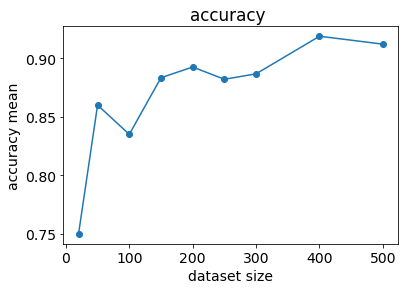

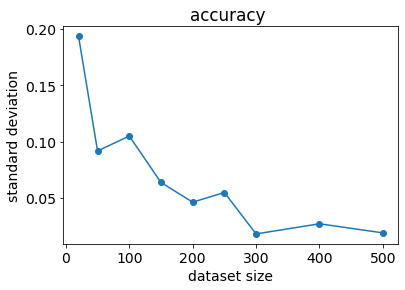

In [18]:
plt.plot(N_samples, acc_xgb_mean, '-o')
plt.xlabel('dataset size')
plt.ylabel('accuracy mean')
plt.title('accuracy ')
plt.show()

plt.plot(N_samples, acc_xgb_stddev, '-o')
plt.xlabel('dataset size')
plt.ylabel('standard deviation')
plt.title('accuracy ')
plt.show()

### Conclusions
As can be seen from the plots above, in the limit of small datasets the test accuracy reached by the XGBoost model is significantly higher than the one by the CNN model. In both cases the standard deviation of the accuracy decreases as the dataset size increases.